# Correlation matrix

In this example, we demonstrate how to apply correlations between random variables using a correlation matrix. When correlations are introduced, the variables no longer vary independently in the variable space but become related to each other. This affects all reliability, uncertainty, and sensitivity simulations.

> Note: using the probabilistic library, two random variables can also be correlated using a copula function.

First, let's import the necessary classes:

In [14]:
from probabilistic_library import UncertaintyProject, DistributionType, UncertaintyMethod
import numpy as np

We consider Hunt's model:

In [15]:
from utils.models import hunt

We create an uncertainty project using the `UncertaintyProject()` class and refer to Hunt’s model:

In [16]:
project = UncertaintyProject()
project.model = hunt

project.model.print()

Model hunt:
Input parameters:
  t_p
  tan_alpha
  h_s
  h_crest
  h
Output parameters:
  Z


We assume the following distributions for the variables:

In [17]:
project.variables["t_p"].distribution = DistributionType.uniform
project.variables["t_p"].minimum = 2
project.variables["t_p"].maximum = 4

project.variables["tan_alpha"].distribution = DistributionType.deterministic
project.variables["tan_alpha"].mean = 0.333333

project.variables["h_s"].distribution = DistributionType.uniform
project.variables["h_s"].minimum = 0
project.variables["h_s"].maximum = 1

project.variables["h_crest"].distribution = DistributionType.log_normal
project.variables["h_crest"].mean = 10
project.variables["h_crest"].deviation = 0.05

project.variables["h"].distribution = DistributionType.uniform
project.variables["h"].minimum = 0
project.variables["h"].maximum = 5

### Uncorrelated variables

We first run the uncertainty analysis without correlations (all variables are assumed to be independent). We use the `crude_monte_carlo` calculation technique and plot the realizations of variables $h_s$ and $t_p$.

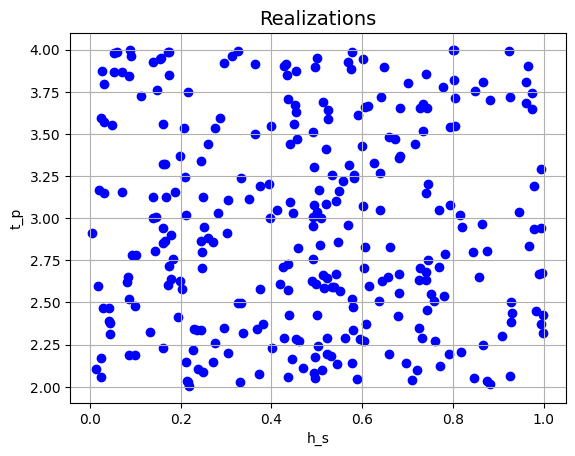

In [18]:
project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.minimum_samples = 300
project.settings.maximum_samples = 300
project.settings.save_realizations = True

project.run()

plt = project.result.get_plot_realizations('h_s', 't_p')
plt.show()

### Correlation matrix (2 variables)

Let's now correlate the variables $h_s$ and $t_p$ using a correlation matrix. We apply a positive correlation coefficient of $0.9$, which implies that higher values of $h_s$ are associated with higher values of $t_p$. The correlation coefficient must be a value in the interval $[-1.0, 1.0]$.

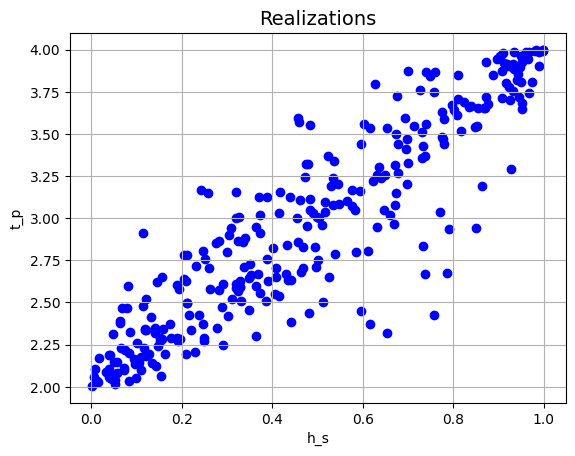

In [19]:
project.correlation_matrix['h_s', 't_p'] = 0.9

project.run()

plt = project.result.get_plot_realizations('h_s', 't_p')
plt.show()


Let’s apply a negative correlation coefficient of $-0.9$, which means that when $h_s$ increases, $t_p$ tends to decrease:

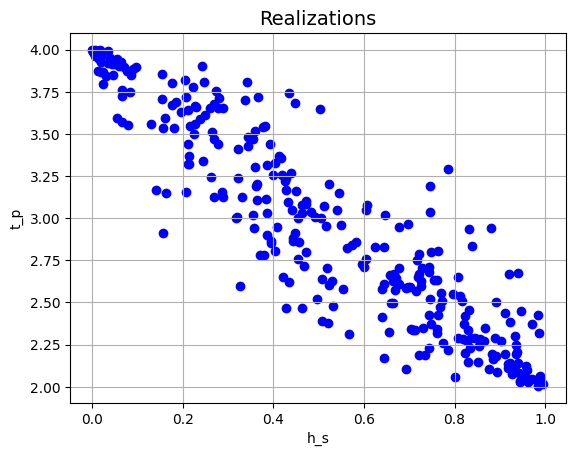

In [20]:
project.correlation_matrix['h_s', 't_p'] = -0.9

project.run()

plt = project.result.get_plot_realizations('h_s', 't_p')
plt.show()

If the correlation coefficient is $0.0$, the variables are independent:

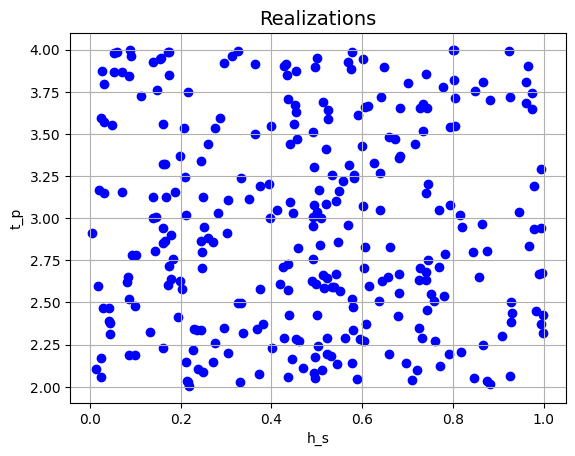

In [21]:
project.correlation_matrix['h_s', 't_p'] = 0.0

project.run()

plt = project.result.get_plot_realizations('h_s', 't_p')
plt.show()

The correlation can only be set between variables that are present in the model. Otherwise, an error message is printed:

In [22]:
project.correlation_matrix['h_s', 'non_existing_variable'] = 0.8

Variable non_existing_variable is not available, value is not set.


### Correlation matrix (more variables)

A correlation matrix must be positive definite. In the case of a correlation matrix of size 2, this is always the case.

For a correlation matrix, the requirement can be checked by assessing the principal minors. A correlation matrix is positive definite when all the minors are positive.

Let's consider a correlation matrix with three variables. We can check if the matrix is positive definite by checking if the determinant of the matrix is positive. This is done with the following method:

In [23]:
def get_determinant_3d(rho_hs_tp, rho_hs_h, rho_tp_h):

    correlation_matrix = np.array([[1.0, rho_hs_tp, rho_hs_h], [rho_hs_tp, 1.0, rho_tp_h], [rho_hs_h, rho_tp_h, 1.0]])

    det = np.linalg.det(correlation_matrix)

    print(f'Determinant: {det}')

Let's now consider a correlation matrix which we know is positive definite; the corresponding determinant is positive:

In [24]:
project.correlation_matrix['h_s', 't_p'] = 0.8
project.correlation_matrix['h_s', 'h'] = 0.6
project.correlation_matrix['t_p', 'h'] = 0.7

get_determinant_3d(project.correlation_matrix['h_s', 't_p'], 
                   project.correlation_matrix['h_s', 'h'], 
                   project.correlation_matrix['t_p', 'h'])


project.validate()

Determinant: 0.1819999999999999
ok


Given this correlation matrix, we run the Monte Carlo simulations:

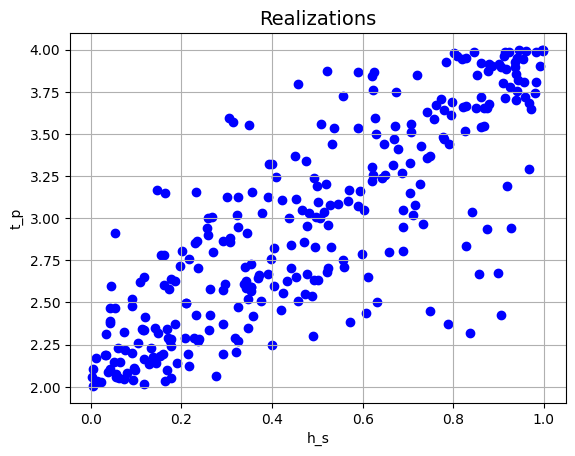

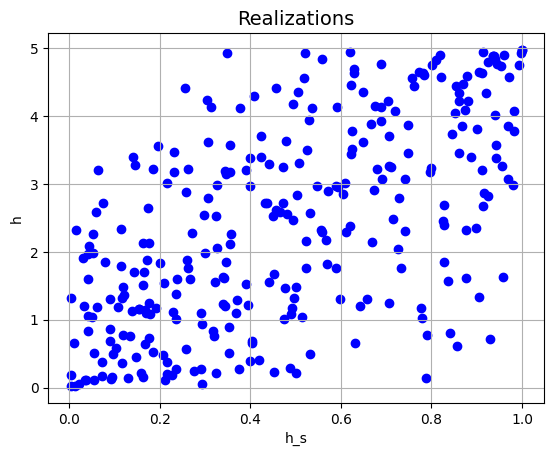

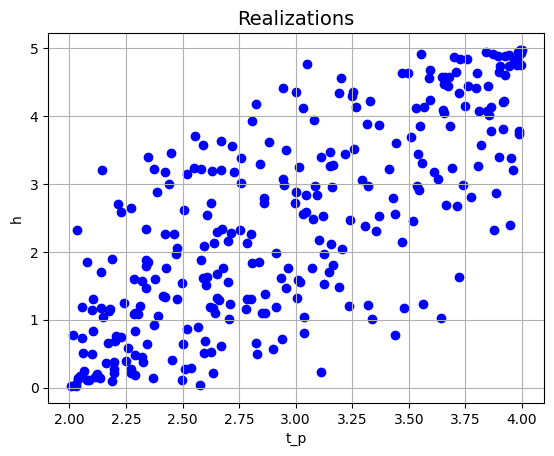

In [25]:
project.run()

plt = project.result.get_plot_realizations('h_s', 't_p')
plt.show()

plt = project.result.get_plot_realizations('h_s', 'h')
plt.show()

plt = project.result.get_plot_realizations('t_p', 'h')
plt.show()

If a correlation matrix is not positive definite (the determinant is negative), an error message is printed indicating that the Cholesky decomposition is not possible:

In [ ]:
project.correlation_matrix['h_s', 't_p'] = 0.9
project.correlation_matrix['h_s', 'h'] = 0.9
project.correlation_matrix['t_p', 'h'] = -0.9

get_determinant_3d(project.correlation_matrix['h_s', 't_p'], 
                   project.correlation_matrix['h_s', 'h'], 
                   project.correlation_matrix['t_p', 'h'])

project.validate()

Determinant: -2.8880000000000003
Error: Cholesky decomposition fails.
